### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 510052 # enter the SSID number to model as an int here, in place of xxxxxxxx
iters = 38 # enter the number of randomised search iterations here 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm

from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR

from sklearn.ensemble import GradientBoostingRegressor as GBR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV

from sklearn.metrics.scorer import make_scorer
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 10.7 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(25259, 12)

time: 342 ms


In [5]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 38 unique JPIDs traversing this segment, over the course of 25259 observations.
time: 4 ms


In [6]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 22 ms


### 1b Adding extra features and altering/dropping existing ones

In [7]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 22 ms


In [8]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(25259, 14)

time: 29 ms


In [9]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 6 ms


In [10]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 7 ms


In [11]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 36 ms


In [12]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 17 ms


In [13]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,139,0.000000,15.0,80,0,Tuesday,8
1,80,0.000000,17.5,80,0,Tuesday,11
2,20,0.000000,17.0,80,0,Tuesday,14
3,43,0.000000,14.0,80,0,Tuesday,18
4,100,0.000000,15.0,80,0,Tuesday,8
5,57,0.000000,17.5,80,0,Tuesday,11
6,23,0.000000,14.0,80,0,Tuesday,21
7,80,0.000000,15.0,80,0,Tuesday,8
8,39,0.000000,17.5,80,0,Tuesday,11
9,61,0.000000,16.5,80,0,Tuesday,15


time: 29 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

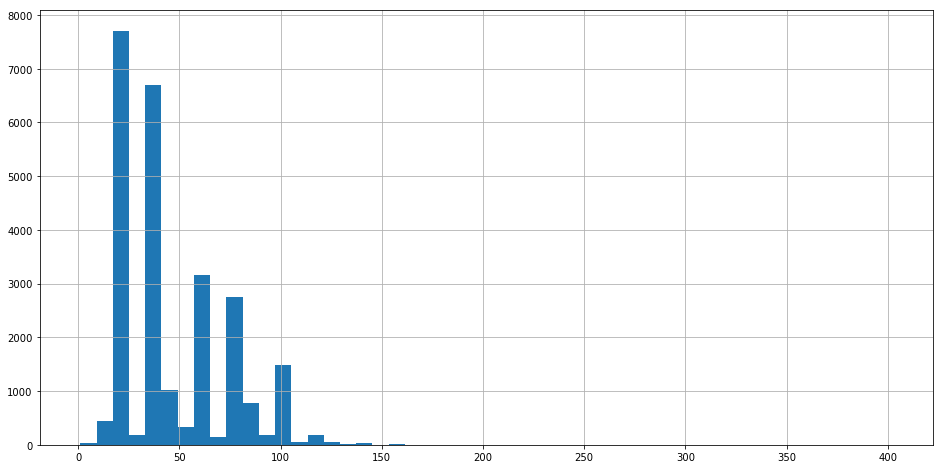

time: 233 ms


In [14]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

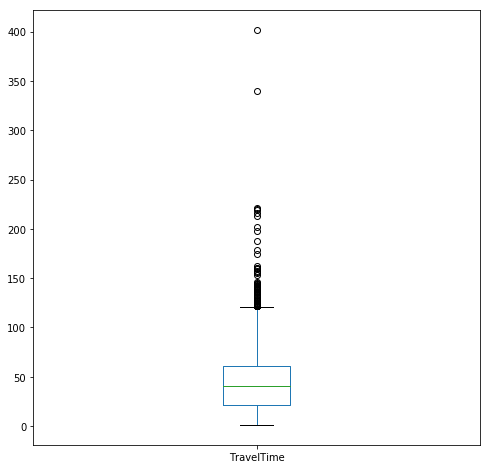

time: 248 ms


In [15]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [16]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    25259.000000
mean        47.010491
std         26.665890
min          1.000000
25%         21.000000
50%         41.000000
75%         61.000000
max        402.000000
Name: TravelTime, dtype: float64

time: 7 ms


Dropping outliers

In [17]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

8.62081178308
time: 10 ms


In [18]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond 3 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (3*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

Outlier_Count = trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0]
Row_Count = Row_Count - Outlier_Count

print("There will be", Outlier_Count, "outliers dropped.")

There will be 32 outliers dropped.
time: 19 ms


In [19]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)

time: 41 ms


In [20]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    25227.000000
mean        46.969794
std         26.336399
min          9.000000
25%         21.000000
50%         41.000000
75%         61.000000
max        179.000000
Name: TravelTime, dtype: float64

time: 8 ms


#### Visualising range of data after dropping outliers

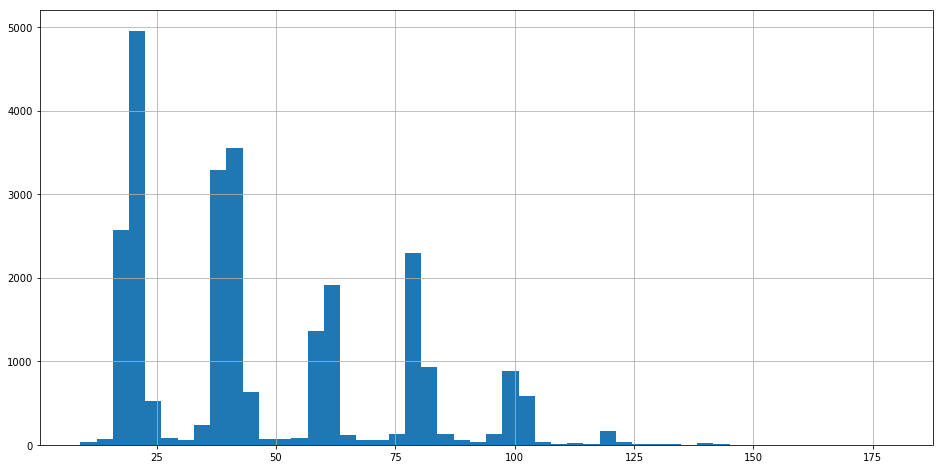

time: 212 ms


In [21]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

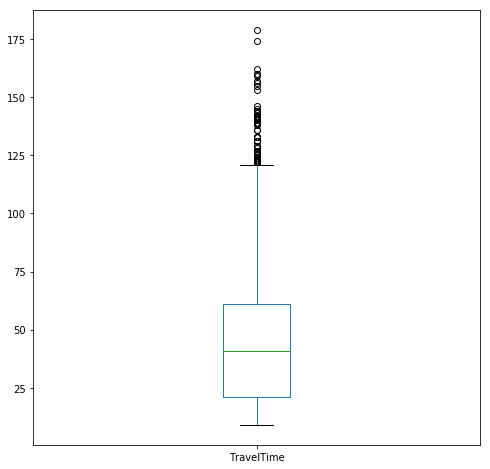

time: 247 ms


In [22]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

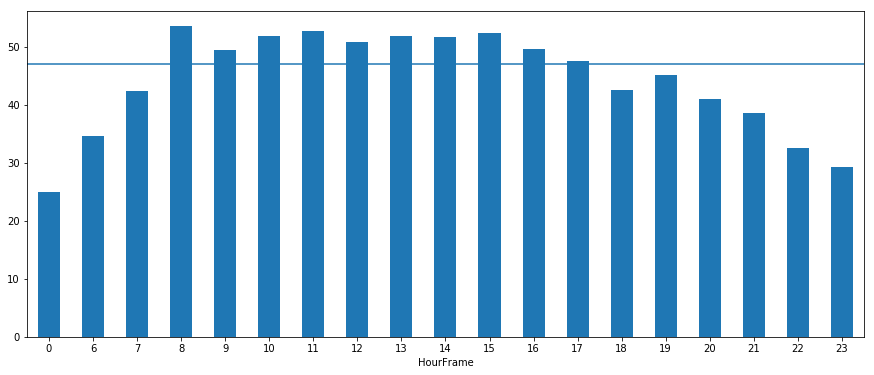

time: 184 ms


In [23]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

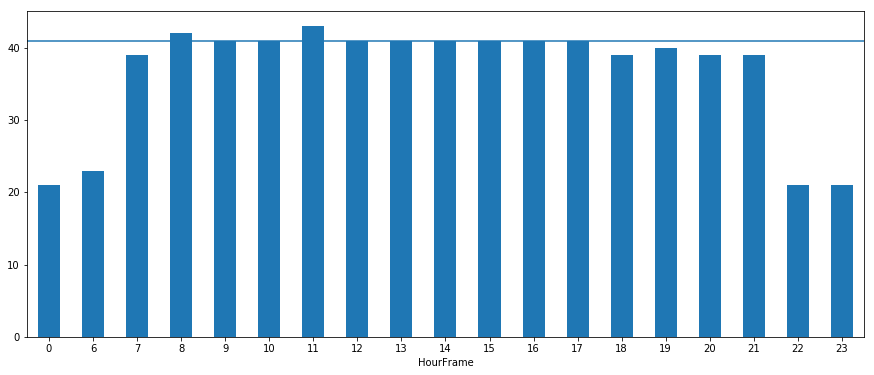

time: 183 ms


In [24]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

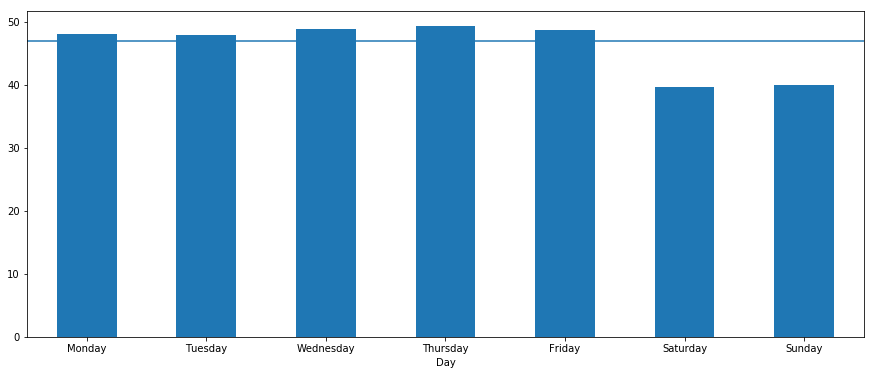

time: 144 ms


In [25]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

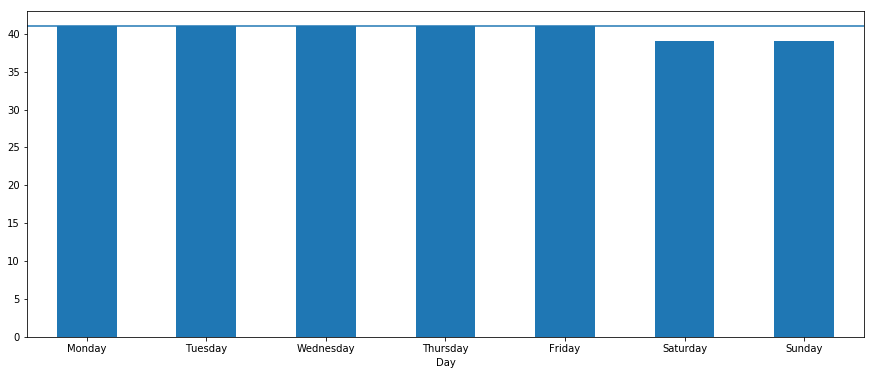

time: 183 ms


In [26]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

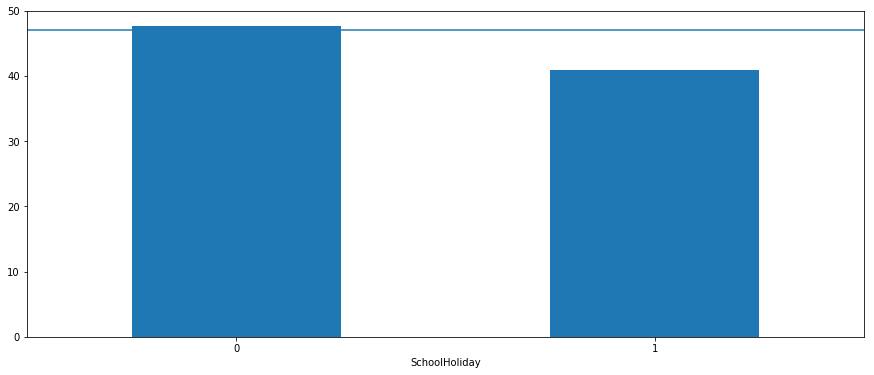

time: 123 ms


In [27]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

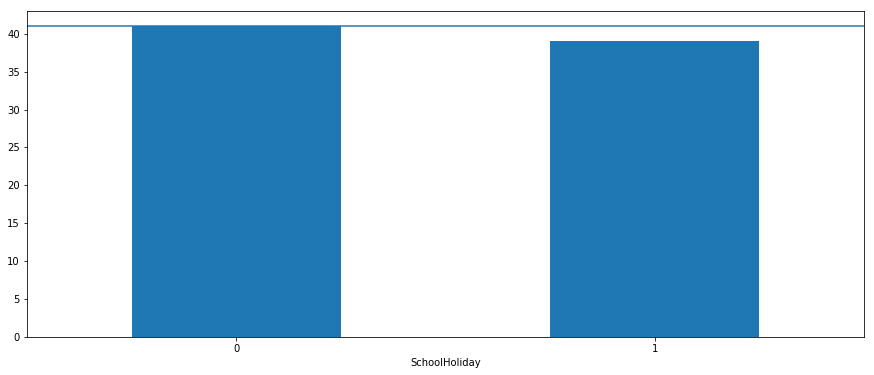

time: 134 ms


In [28]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [29]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,HF_6,HF_7,HF_8,HF_9,HF_10,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,179,0.000000,3.0,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,174,0.000000,11.5,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,162,0.000000,13.5,93,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,160,0.000000,6.0,59,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,160,0.000000,17.5,93,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,159,0.000000,6.0,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,157,0.899902,4.5,53,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,156,0.000000,21.5,80,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
8,155,1.266667,3.5,48,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
9,153,0.000000,2.5,80,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 55 ms


In [30]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 1 ms


In [31]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [32]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 6 ms


For comparison purposes, first train on Linear Regression

### 3.2a Linear Regression model (via scikit-learn) - training - default parameters

In [33]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 66 ms


In [34]:

lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)
print()
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))
print()
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.0850064179834

The mean absolute error of the Linear Regression model is 20.8236740141
The mean absolute percentage error is 44.3341818685

The median absolute error of the Linear Regression model is 18.6411493973
The median absolute percentage error is 45.4662180423
time: 12 ms


### 3.2b Linear Regression model (via scikit-learn) - testing - default parameters

In [35]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)
print()
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))
print()
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.0807977997354

The mean absolute error of the Linear Regression model is 20.8338561091
The mean absolute percentage error is 44.3558598325

The median absolute error of the Linear Regression model is 18.3697215585
The median absolute percentage error is 44.8041989231
time: 11 ms


### 3.3a Gradient Boosting Regression model - training - default parameters

In [36]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 864 ms


In [37]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_length 	 0.231495996182
WindSpeed 	 0.071853633702
Day_Saturday 	 0.0612350095247
HF_22 	 0.0572814722609
Day_Sunday 	 0.0552237206918
HF_23 	 0.0542190442923
Rain 	 0.0440822048973
HF_6 	 0.0433515775409
HF_8 	 0.0429384046994
HF_7 	 0.041592245077
HF_18 	 0.0388209227875
SchoolHoliday 	 0.0370165158081
HF_21 	 0.0369487357429
HF_20 	 0.030741601356
HF_19 	 0.0189354163998
HF_14 	 0.0170676473376
HF_11 	 0.0165589940057
HF_10 	 0.0165163677448
HF_15 	 0.0158753013585
Day_Tuesday 	 0.0149644533374
HF_13 	 0.0111535314544
Day_Monday 	 0.0109592059282
HF_17 	 0.00973670384316
HF_12 	 0.00866547948032
Day_Wednesday 	 0.00696867083177
Day_Thursday 	 0.00325862621117
HF_9 	 0.00253851750471
HF_16 	 0.0
time: 67 ms


In [38]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.115591252046

The mean absolute error of the trained Gradient Boosting Regression model is 20.439160861
The mean absolute percentage error is 43.5155426577

The median absolute error of the trained Gradient Boosting Regression model is 18.786560409
The median absolute percentage error is 45.8208790464
time: 33 ms


### 3.3b Gradient Boosting Regression model - - testing - default parameters

In [39]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.103421042408

The mean absolute error of the trained Gradient Boosting Regression model is 20.502981222
The mean absolute percentage error is 43.6514179836

The median absolute error of the trained Gradient Boosting Regression model is 18.8798968585
The median absolute percentage error is 46.0485289232
time: 19 ms


### 3.4a Gradient Boosting Regression model - training - LAD loss function 

In [40]:
gbr = GBR(loss='lad')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 1.03 s


In [41]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_length 	 0.249988913776
HF_23 	 0.0948097735095
WindSpeed 	 0.0795180100504
HF_22 	 0.0765864561434
Day_Saturday 	 0.0754048183533
Rain 	 0.0724072822202
HF_7 	 0.0653238346924
Day_Sunday 	 0.0369570079175
HF_18 	 0.0345793998308
HF_8 	 0.0302463374377
SchoolHoliday 	 0.0277349371108
HF_21 	 0.0254730318326
HF_20 	 0.0213430327044
HF_10 	 0.0137383530386
HF_15 	 0.0121885621609
HF_12 	 0.0118421252626
HF_6 	 0.011633703865
HF_14 	 0.0112450036857
Day_Wednesday 	 0.00888917840329
Day_Tuesday 	 0.0085468799361
HF_11 	 0.00820146129025
HF_17 	 0.00765899480735
Day_Thursday 	 0.0045327687781
HF_13 	 0.00410391338751
HF_19 	 0.00285329459704
Day_Monday 	 0.00231450084843
HF_9 	 0.00187842435973
HF_16 	 0.0
time: 64 ms


In [42]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.0072312096281

The mean absolute error of the trained Gradient Boosting Regression model is 19.8138748049
The mean absolute percentage error is 42.1842912316

The median absolute error of the trained Gradient Boosting Regression model is 18.6631564531
The median absolute percentage error is 45.5198937881
time: 33 ms


### 3.4b Gradient Boosting Regression model - testing - LAD loss function 

In [43]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.00182247441133

The mean absolute error of the trained Gradient Boosting Regression model is 19.8056852021
The mean absolute percentage error is 42.1668553392

The median absolute error of the trained Gradient Boosting Regression model is 18.6175969446
The median absolute percentage error is 45.4087730357
time: 19 ms


### 3.5a Gradient Boosting Regression model - training - HUBER loss function 

In [44]:
gbr = GBR(loss='huber')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

time: 1.24 s


In [45]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_length 	 0.211636508891
Day_Sunday 	 0.0715075236527
WindSpeed 	 0.0643243518767
Day_Saturday 	 0.0628098582149
HF_22 	 0.0585749301691
HF_23 	 0.0530106578761
HF_8 	 0.0440482803846
HF_21 	 0.0440198967844
HF_6 	 0.0418466029439
Rain 	 0.0411060724784
HF_18 	 0.0398181433491
SchoolHoliday 	 0.0384330957089
HF_7 	 0.0376401223132
HF_20 	 0.0317198622754
HF_19 	 0.0182850979246
Day_Tuesday 	 0.0181951387033
HF_14 	 0.0175147668027
HF_11 	 0.0173384095476
HF_15 	 0.0150272450021
HF_10 	 0.0143935137639
Day_Thursday 	 0.0115272202711
HF_17 	 0.0111288440394
HF_13 	 0.0108068444361
HF_12 	 0.00927013141625
Day_Monday 	 0.00843153877386
Day_Wednesday 	 0.00672507722574
HF_9 	 0.000860265175186
HF_16 	 0.0
time: 67 ms


In [46]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.107892825971

The mean absolute error of the trained Gradient Boosting Regression model is 20.1744527512
The mean absolute percentage error is 42.9519717206

The median absolute error of the trained Gradient Boosting Regression model is 18.1164413926
The median absolute percentage error is 44.1864424209
time: 33 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [47]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.0969503458815

The mean absolute error of the trained Gradient Boosting Regression model is 20.2203951257
The mean absolute percentage error is 43.0497843152

The median absolute error of the trained Gradient Boosting Regression model is 18.2813002584
The median absolute percentage error is 44.5885372157
time: 18 ms


## 4 Parameter tuning with RandomizedSearchCV

In [48]:
print("Note that there are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

Note that there are 38 unique JPIDs traversing this segment, over the course of 25227 observations.
Error in callback <bound method LineWatcher.stop of <autotime.LineWatcher object at 0x0000000008560710>> (for post_run_cell):


AssertionError: 

In [49]:
STOP HERE - from results above, select best loss function for each of the three trainings below,

SyntaxError: invalid syntax (<ipython-input-49-df044ab76723>, line 1)

### 4a Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

##### Train with Median Absolute Error as scorer

In [50]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 6 ms


In [51]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A8D62B0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002BB41A58>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002BB3BDD8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002BB8C2E8>, 'learning_rate': <scipy.stats._distn_inf

time: 17min 30s


In [52]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.18056030838343398, 'max_depth': 9, 'min_samples_leaf': 99, 'min_samples_split': 422, 'n_estimators': 692}
time: 1e+03 µs


In [53]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 17.8211994307
Best MdAPE found is 43.466%
time: 3 ms


In [54]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-15.336240,-17.821199,692,9,99,422,0.18056,25.3728,0.0864
1,2,-15.596957,-17.824060,525,9,72,623,0.209484,17.8260,0.0600
2,3,-15.887270,-17.850941,1210,7,71,642,0.124596,32.3318,0.1074
3,4,-16.178293,-17.874762,638,9,39,483,0.0673676,22.2122,0.0728
4,5,-15.027615,-17.892511,843,9,50,257,0.112025,33.4998,0.1024
5,6,-15.909393,-17.904420,209,9,8,678,0.287509,6.8732,0.0240
6,7,-15.257931,-17.921527,1358,6,83,417,0.267143,34.5630,0.1122
7,8,-15.301028,-17.929877,1129,7,73,792,0.296815,30.2382,0.1006
8,9,-15.912222,-17.945631,1351,6,93,608,0.186793,31.9480,0.1070
9,10,-16.640349,-17.954182,906,7,82,405,0.0501495,24.2454,0.0862


time: 31 ms


In [55]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.0577962747956

Mean absolute error of best model on the test set is 20.448090416
Mean absolute percentage error of best model on the test set is 49.873%

Median absolute error of best model on the test set is 17.6412290653
Median absolute percentage error of best model on the test set is 43.027%
time: 194 ms


##### Train with Mean Absolute Error as scorer

In [56]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 5 ms


In [57]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.mean_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000067E84E0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000067E8A90>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000067E8C88>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000067E8D68>, 'learning_rate': <scipy.stats._distn_inf

time: 21min 6s


In [58]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.096418954632868911, 'max_depth': 9, 'min_samples_leaf': 87, 'min_samples_split': 690, 'n_estimators': 97}
time: 1 ms


In [59]:
gbr_train_MAE = abs(gbr_rsearch.best_score_)
gbr_train_MAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best Mean absolute error found is", gbr_train_MAE)
print ("Best Mean absolute percentage error found is", str(round(gbr_train_MAPE, 3)) + "%")

Best Mean absolute error found is 20.2196033827
Best Mean absolute percentage error found is 43.466%
time: 5 ms


In [60]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-19.643172,-20.219603,97,9,87,690,0.096419,2.8340,0.0118
1,2,-19.622397,-20.225150,278,7,79,591,0.0474928,6.6460,0.0256
2,3,-19.488935,-20.241858,972,5,46,725,0.0474484,15.6568,0.0592
3,4,-19.575668,-20.242302,92,7,85,927,0.261858,2.0752,0.0088
4,5,-19.756980,-20.247097,130,4,57,402,0.152155,1.8074,0.0078
5,6,-19.397209,-20.247649,139,7,37,816,0.196402,3.1310,0.0138
6,7,-19.195216,-20.273595,1384,6,23,809,0.0505795,27.6146,0.1010
7,8,-19.451504,-20.273762,1364,3,21,643,0.272337,14.4116,0.0560
8,9,-19.314743,-20.275938,242,7,73,474,0.10264,6.1448,0.0236
9,10,-19.197217,-20.278124,179,5,34,397,0.255524,3.1208,0.0120


time: 31 ms


In [61]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.105222009776

Mean absolute error of best model on the test set is 20.0631847197
Mean absolute percentage error of best model on the test set is 48.935%

Median absolute error of best model on the test set is 17.9497498657
Median absolute percentage error of best model on the test set is 43.78%
time: 36 ms


##### Train with R-squared value as scorer

In [92]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 6 ms


In [93]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.r2_score))
gbr_rsearch.fit(X_train, y_train)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...Bus\\lib\\site-packages\\ipykernel\\__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\runpy.py in _run_code(code=<code object <module> at 0x00000000029FBC00, fil...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...Bus\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\CS\\Anac...us\\lib\\site-packages\\ipykernel\\kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...Bus\\lib\\site-packages\\ipykernel\\__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000000029FBC00, fil...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\__pycache__\__main__.cpython-36.pyc', '__doc__': None, '__file__': r'C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...Bus\\lib\\site-packages\\ipykernel\\__main__.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\CS\\Anac...us\\lib\\site-packages\\ipykernel\\kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gbr_rsearch = RSCV(gbr, param_distributions=para...rics.r2_score))\ngbr_rsearch.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 8, 22, 2, 12, 27, 858000, tzinfo=tzlocal()), 'msg_id': 'C1F1EBD54D014EB689EA222BB62C70A5', 'msg_type': 'execute_request', 'session': 'F1907572BEA64B59B54558C63F13C11F', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C1F1EBD54D014EB689EA222BB62C70A5', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'F1907572BEA64B59B54558C63F13C11F']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'gbr_rsearch = RSCV(gbr, param_distributions=para...rics.r2_score))\ngbr_rsearch.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 8, 22, 2, 12, 27, 858000, tzinfo=tzlocal()), 'msg_id': 'C1F1EBD54D014EB689EA222BB62C70A5', 'msg_type': 'execute_request', 'session': 'F1907572BEA64B59B54558C63F13C11F', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C1F1EBD54D014EB689EA222BB62C70A5', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'F1907572BEA64B59B54558C63F13C11F'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gbr_rsearch = RSCV(gbr, param_distributions=para...rics.r2_score))\ngbr_rsearch.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 8, 22, 2, 12, 27, 858000, tzinfo=tzlocal()), 'msg_id': 'C1F1EBD54D014EB689EA222BB62C70A5', 'msg_type': 'execute_request', 'session': 'F1907572BEA64B59B54558C63F13C11F', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C1F1EBD54D014EB689EA222BB62C70A5', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='gbr_rsearch = RSCV(gbr, param_distributions=para...rics.r2_score))\ngbr_rsearch.fit(X_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'gbr_rsearch = RSCV(gbr, param_distributions=para...rics.r2_score))\ngbr_rsearch.fit(X_train, y_train)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('gbr_rsearch = RSCV(gbr, param_distributions=para...rics.r2_score))\ngbr_rsearch.fit(X_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('gbr_rsearch = RSCV(gbr, param_distributions=para...rics.r2_score))\ngbr_rsearch.fit(X_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='gbr_rsearch = RSCV(gbr, param_distributions=para...rics.r2_score))\ngbr_rsearch.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-93-792103d396a6>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 68eb898, execution_co..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000000006A0DE40, file "<ipython-input-93-792103d396a6>", line 2>
        result = <ExecutionResult object at 68eb898, execution_co..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000000006A0DE40, file "<ipython-input-93-792103d396a6>", line 2>, result=<ExecutionResult object at 68eb898, execution_co..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000000006A0DE40, file "<ipython-input-93-792103d396a6>", line 2>
        self.user_global_ns = {'Day_dummies':        Day_Monday  Day_Saturday  Day_Sunday  Day...
25226              1  

[25227 rows x 6 columns], 'GBR': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'HF_dummies':        HF_6  HF_7  HF_8  HF_9  HF_10  HF_11  HF_...     0      0      0  

[25227 rows x 18 columns], 'In': ['', '# setting variables\n\ncores = 3 # enter the numbe... the number of randomised search iterations here ', 'import pandas as pd\nimport numpy as np\nimport ma...xport_graphviz\n#from IPython.display import Image', "# Read in stop_times.txt and trips.txt files fro...csv' % r)\n    res = pd.concat([df, res], axis=0) ", "# create dataframe for SSIDno\n\nres['SSID'] = res..._df = ssid_df.drop('index', axis=1)\nssid_df.shape", 'JPID_Count = ssid_df.JourneyPatternID.unique().s... over the course of", Row_Count, "observations.")', '# add leading zeroes to JourneyPatternID\n\nssid_d...JourneyPatternID.apply(lambda x: str(x).zfill(8))', "# adding Xbuses feature - boolean feature indica...id_df['XBuses'] = ssid_df['XBuses'].astype('int')", "# adding JPID_length feature - represents the to...ternID')\nssid_df = ssid_df.dropna()\nssid_df.shape", "# removing non-holiday-period weekends from Scho...'2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)", "# dropping unneeded columns\n\nssid_df = ssid_df.d..., 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]", "# assigning appropriate datatypes where necessar...D_length'] = ssid_df['JPID_length'].astype('int')", '# removing any constant features\n# code from: ht...d_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]', 'ssid_df', 'ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)', "ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)", '# Checking stats for TravelTime\n\nssid_df.TravelTime.describe()', "# loading table of minimum times to traverse seg...b['SSID'] == SSIDno, 'min_sec'].iloc[0]\nprint(lb)", '# make a copy of original df\n\ntrimssid_df = ssid...ere will be", Outlier_Count, "outliers dropped.")', "# dropping outliers\n\ntrimssid_df = trimssid_df[t...)\ntrimssid_df = trimssid_df.drop('index', axis=1)", ...], 'JPIDL':     JourneyPatternID  JPID_length
0           00...    00091002           37

[478 rows x 2 columns], 'JPID_Count': 38, 'LinR': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {4: (25259, 12), 8: (25259, 14), 13:        TravelTime      Rain  WindSpeed  JPID_len... 18  
25258         8  

[25259 rows x 7 columns], 14: <matplotlib.axes._subplots.AxesSubplot object>, 15: <matplotlib.axes._subplots.AxesSubplot object>, 16: count    25259.000000
mean        47.010491
std ...      402.000000
Name: TravelTime, dtype: float64, 20: count    25227.000000
mean        46.969794
std ...      179.000000
Name: TravelTime, dtype: float64, 21: <matplotlib.axes._subplots.AxesSubplot object>, 22: <matplotlib.axes._subplots.AxesSubplot object>, 23: [<matplotlib.lines.Line2D object>], ...}, 'Outlier_Count': 32, 'RSCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, ...}
        self.user_ns = {'Day_dummies':        Day_Monday  Day_Saturday  Day_Sunday  Day...
25226              1  

[25227 rows x 6 columns], 'GBR': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'HF_dummies':        HF_6  HF_7  HF_8  HF_9  HF_10  HF_11  HF_...     0      0      0  

[25227 rows x 18 columns], 'In': ['', '# setting variables\n\ncores = 3 # enter the numbe... the number of randomised search iterations here ', 'import pandas as pd\nimport numpy as np\nimport ma...xport_graphviz\n#from IPython.display import Image', "# Read in stop_times.txt and trips.txt files fro...csv' % r)\n    res = pd.concat([df, res], axis=0) ", "# create dataframe for SSIDno\n\nres['SSID'] = res..._df = ssid_df.drop('index', axis=1)\nssid_df.shape", 'JPID_Count = ssid_df.JourneyPatternID.unique().s... over the course of", Row_Count, "observations.")', '# add leading zeroes to JourneyPatternID\n\nssid_d...JourneyPatternID.apply(lambda x: str(x).zfill(8))', "# adding Xbuses feature - boolean feature indica...id_df['XBuses'] = ssid_df['XBuses'].astype('int')", "# adding JPID_length feature - represents the to...ternID')\nssid_df = ssid_df.dropna()\nssid_df.shape", "# removing non-holiday-period weekends from Scho...'2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)", "# dropping unneeded columns\n\nssid_df = ssid_df.d..., 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]", "# assigning appropriate datatypes where necessar...D_length'] = ssid_df['JPID_length'].astype('int')", '# removing any constant features\n# code from: ht...d_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]', 'ssid_df', 'ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)', "ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)", '# Checking stats for TravelTime\n\nssid_df.TravelTime.describe()', "# loading table of minimum times to traverse seg...b['SSID'] == SSIDno, 'min_sec'].iloc[0]\nprint(lb)", '# make a copy of original df\n\ntrimssid_df = ssid...ere will be", Outlier_Count, "outliers dropped.")', "# dropping outliers\n\ntrimssid_df = trimssid_df[t...)\ntrimssid_df = trimssid_df.drop('index', axis=1)", ...], 'JPIDL':     JourneyPatternID  JPID_length
0           00...    00091002           37

[478 rows x 2 columns], 'JPID_Count': 38, 'LinR': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {4: (25259, 12), 8: (25259, 14), 13:        TravelTime      Rain  WindSpeed  JPID_len... 18  
25258         8  

[25259 rows x 7 columns], 14: <matplotlib.axes._subplots.AxesSubplot object>, 15: <matplotlib.axes._subplots.AxesSubplot object>, 16: count    25259.000000
mean        47.010491
std ...      402.000000
Name: TravelTime, dtype: float64, 20: count    25227.000000
mean        46.969794
std ...      179.000000
Name: TravelTime, dtype: float64, 21: <matplotlib.axes._subplots.AxesSubplot object>, 22: <matplotlib.axes._subplots.AxesSubplot object>, 23: [<matplotlib.lines.Line2D object>], ...}, 'Outlier_Count': 32, 'RSCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
D:\HDipCS\COMP47360_Research_Practicum\SSID time output\<ipython-input-93-792103d396a6> in <module>()
      1 
----> 2 
      3 
      4 
      5 gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.r2_score))
      6 gbr_rsearch.fit(X_train, y_train)
      7 
      8 
      9 
     10 

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\model_selection\_search.py in fit(self=RandomizedSearchCV(cv=5, error_score='raise',
  ...oring=make_scorer(r2_score),
          verbose=0), X=           Rain  WindSpeed  JPID_length  SchoolH...20533              0  

[17658 rows x 28 columns], y=16400     37
6957      60
5792      63
5459     ... 20
Name: TravelTime, Length: 17658, dtype: int64, groups=None)
   1185             train/test set.
   1186         """
   1187         sampled_params = ParameterSampler(self.param_distributions,
   1188                                           self.n_iter,
   1189                                           random_state=self.random_state)
-> 1190         return self._fit(X, y, groups, sampled_params)
        self._fit = <bound method BaseSearchCV._fit of RandomizedSea...ring=make_scorer(r2_score),
          verbose=0)>
        X =            Rain  WindSpeed  JPID_length  SchoolH...20533              0  

[17658 rows x 28 columns]
        y = 16400     37
6957      60
5792      63
5459     ... 20
Name: TravelTime, Length: 17658, dtype: int64
        groups = None
        sampled_params = <sklearn.model_selection._search.ParameterSampler object>
   1191 
   1192 
   1193 
   1194 

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\model_selection\_search.py in _fit(self=RandomizedSearchCV(cv=5, error_score='raise',
  ...oring=make_scorer(r2_score),
          verbose=0), X=           Rain  WindSpeed  JPID_length  SchoolH...20533              0  

[17658 rows x 28 columns], y=16400     37
6957      60
5792      63
5459     ... 20
Name: TravelTime, Length: 17658, dtype: int64, groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterSampler object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterSampler object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=3), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=3)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Aug 22 02:12:28 2017
PID: 3632            Python 3.6.1: C:\CS\Anaconda\envs\DublinBus\python.exe
...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False),            Rain  WindSpeed  JPID_length  SchoolH...20533              0  

[17658 rows x 28 columns], 16400     37
6957      60
5792      63
5459     ... 20
Name: TravelTime, Length: 17658, dtype: int64, make_scorer(r2_score), array([ 3532,  3533,  3534, ..., 17655, 17656, 17657]), array([   0,    1,    2, ..., 3529, 3530, 3531]), 0, {'learning_rate': 0.066007332885851477, 'max_depth': 7, 'min_samples_leaf': 27, 'min_samples_split': 1.3428354021176023, 'n_estimators': 1075}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False),            Rain  WindSpeed  JPID_length  SchoolH...20533              0  

[17658 rows x 28 columns], 16400     37
6957      60
5792      63
5459     ... 20
Name: TravelTime, Length: 17658, dtype: int64, make_scorer(r2_score), array([ 3532,  3533,  3534, ..., 17655, 17656, 17657]), array([   0,    1,    2, ..., 3529, 3530, 3531]), 0, {'learning_rate': 0.066007332885851477, 'max_depth': 7, 'min_samples_leaf': 27, 'min_samples_split': 1.3428354021176023, 'n_estimators': 1075})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), X=           Rain  WindSpeed  JPID_length  SchoolH...20533              0  

[17658 rows x 28 columns], y=16400     37
6957      60
5792      63
5459     ... 20
Name: TravelTime, Length: 17658, dtype: int64, scorer=make_scorer(r2_score), train=array([ 3532,  3533,  3534, ..., 17655, 17656, 17657]), test=array([   0,    1,    2, ..., 3529, 3530, 3531]), verbose=0, parameters={'learning_rate': 0.066007332885851477, 'max_depth': 7, 'min_samples_leaf': 27, 'min_samples_split': 1.3428354021176023, 'n_estimators': 1075}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    233 
    234     try:
    235         if y_train is None:
    236             estimator.fit(X_train, **fit_params)
    237         else:
--> 238             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseGradientBoosting.fit of Gradie...e=1.0, verbose=0,
             warm_start=False)>
        X_train =            Rain  WindSpeed  JPID_length  SchoolH...20533              0  

[14126 rows x 28 columns]
        y_train = 4123      80
660      101
14611     39
10154    ... 20
Name: TravelTime, Length: 14126, dtype: int64
        fit_params = {}
    239 
    240     except Exception as e:
    241         # Note fit time as time until error
    242         fit_time = time.time() - start_time

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\ensemble\gradient_boosting.py in fit(self=GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), X=array([[  0. ,   4. ,  53. , ...,   1. ,   0. , ... 93. , ...,   0. ,   0. ,   0. ]], dtype=float32), y=array([ 80, 101,  39, ...,  79,  39,  20], dtype=int64), sample_weight=array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), monitor=None)
   1023                 X_idx_sorted = np.asfortranarray(np.argsort(X, axis=0),
   1024                                                  dtype=np.int32)
   1025 
   1026         # fit the boosting stages
   1027         n_stages = self._fit_stages(X, y, y_pred, sample_weight, random_state,
-> 1028                                     begin_at_stage, monitor, X_idx_sorted)
        begin_at_stage = 0
        monitor = None
        X_idx_sorted = array([[    0, 11142, 10458, ...,  7062,     0, ...[ 1485,  9133,  6332, ...,     0,  2134,  7062]])
   1029         # change shape of arrays after fit (early-stopping or additional ests)
   1030         if n_stages != self.estimators_.shape[0]:
   1031             self.estimators_ = self.estimators_[:n_stages]
   1032             self.train_score_ = self.train_score_[:n_stages]

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\ensemble\gradient_boosting.py in _fit_stages(self=GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), X=array([[  0. ,   4. ,  53. , ...,   1. ,   0. , ... 93. , ...,   0. ,   0. ,   0. ]], dtype=float32), y=array([ 80, 101,  39, ...,  79,  39,  20], dtype=int64), y_pred=array([[ 41.],
       [ 41.],
       [ 41.],
   ...., 
       [ 41.],
       [ 41.],
       [ 41.]]), sample_weight=array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), random_state=<mtrand.RandomState object>, begin_at_stage=0, monitor=None, X_idx_sorted=array([[    0, 11142, 10458, ...,  7062,     0, ...[ 1485,  9133,  6332, ...,     0,  2134,  7062]]))
   1078                                       sample_weight[~sample_mask])
   1079 
   1080             # fit next stage of trees
   1081             y_pred = self._fit_stage(i, X, y, y_pred, sample_weight,
   1082                                      sample_mask, random_state, X_idx_sorted,
-> 1083                                      X_csc, X_csr)
        X_csc = None
        X_csr = None
   1084 
   1085             # track deviance (= loss)
   1086             if do_oob:
   1087                 self.train_score_[i] = loss_(y[sample_mask],

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\ensemble\gradient_boosting.py in _fit_stage(self=GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), i=0, X=array([[  0. ,   4. ,  53. , ...,   1. ,   0. , ... 93. , ...,   0. ,   0. ,   0. ]], dtype=float32), y=array([ 80, 101,  39, ...,  79,  39,  20], dtype=int64), y_pred=array([[ 41.],
       [ 41.],
       [ 41.],
   ...., 
       [ 41.],
       [ 41.],
       [ 41.]]), sample_weight=array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), sample_mask=array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), random_state=<mtrand.RandomState object>, X_idx_sorted=array([[    0, 11142, 10458, ...,  7062,     0, ...[ 1485,  9133,  6332, ...,     0,  2134,  7062]]), X_csc=None, X_csr=None)
    782             if X_csc is not None:
    783                 tree.fit(X_csc, residual, sample_weight=sample_weight,
    784                          check_input=False, X_idx_sorted=X_idx_sorted)
    785             else:
    786                 tree.fit(X, residual, sample_weight=sample_weight,
--> 787                          check_input=False, X_idx_sorted=X_idx_sorted)
        X_idx_sorted = array([[    0, 11142, 10458, ...,  7062,     0, ...[ 1485,  9133,  6332, ...,     0,  2134,  7062]])
    788 
    789             # update tree leaves
    790             if X_csr is not None:
    791                 loss.update_terminal_regions(tree.tree_, X_csr, y, residual, y_pred,

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='friedman_mse', ... 0x0000000003883798>,
           splitter='best'), X=array([[  0. ,   4. ,  53. , ...,   1. ,   0. , ... 93. , ...,   0. ,   0. ,   0. ]], dtype=float32), y=array([ 39.,  41.,  -2., ...,  38.,  -2., -21.]), sample_weight=array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), check_input=False, X_idx_sorted=array([[    0, 11142, 10458, ...,  7062,     0, ...[ 1485,  9133,  6332, ...,     0,  2134,  7062]]))
   1024 
   1025         super(DecisionTreeRegressor, self).fit(
   1026             X, y,
   1027             sample_weight=sample_weight,
   1028             check_input=check_input,
-> 1029             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = array([[    0, 11142, 10458, ...,  7062,     0, ...[ 1485,  9133,  6332, ...,     0,  2134,  7062]])
   1030         return self
   1031 
   1032 
   1033 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='friedman_mse', ... 0x0000000003883798>,
           splitter='best'), X=array([[  0. ,   4. ,  53. , ...,   1. ,   0. , ... 93. , ...,   0. ,   0. ,   0. ]], dtype=float32), y=array([[ 39.],
       [ 41.],
       [ -2.],
   ...., 
       [ 38.],
       [ -2.],
       [-21.]]), sample_weight=array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), check_input=False, X_idx_sorted=array([[    0, 11142, 10458, ...,  7062,     0, ...[ 1485,  9133,  6332, ...,     0,  2134,  7062]]))
    200             min_samples_split = self.min_samples_split
    201         else:  # float
    202             if not 0. < self.min_samples_split <= 1.:
    203                 raise ValueError("min_samples_split must be at least 2 "
    204                                  "or in (0, 1], got %s"
--> 205                                  % self.min_samples_split)
        self.min_samples_split = 1.3428354021176023
    206             min_samples_split = int(ceil(self.min_samples_split * n_samples))
    207             min_samples_split = max(2, min_samples_split)
    208 
    209         min_samples_split = max(min_samples_split, 2 * min_samples_leaf)

ValueError: min_samples_split must be at least 2 or in (0, 1], got 1.34283540212
___________________________________________________________________________

time: 1.65 s


In [ ]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

In [ ]:
gbr_train_rsqa = abs(gbr_rsearch.best_score_)

print("Best R-squared value found is", gbr_train_rsqa)

In [ ]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

In [ ]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

#### 4b Gradient Boosting with new parameter ranges

In [101]:
mss = int(Row_Count/100)
gbr = GBR(loss='huber', min_samples_split = mss)

param_gbr = {'n_estimators': stats.randint(50, 300),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(1, 75),
            'learning_rate': stats.uniform(0.001, 0.1),
            'subsample': [0.6, 0.7, 0.8, 0.9]}


time: 6 ms


In [102]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.mean_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=252, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006994AC8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006994160>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006994438>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006994898>, 'subsample': [0.6, 0.7, 0.8, 0.9]},
      

time: 5min 16s


In [103]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.039714888443438193, 'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 245, 'subsample': 0.8}
time: 1e+03 µs


In [104]:
gbr_train_MAE = abs(gbr_rsearch.best_score_)
gbr_train_MAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best Mean absolute error found is", gbr_train_MAE)
print ("Best Mean absolute percentage error found is", str(round(gbr_train_MAPE, 3)) + "%")

Best Mean absolute error found is 20.1849340049
Best Mean absolute percentage error found is 43.466%
time: 4 ms


In [106]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_learning_rate', 'param_subsample', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_learning_rate,param_subsample,mean_fit_time,mean_score_time
0,1,-19.494784,-20.184934,245,6,5,0.0397149,0.8,5.9112,0.0210
1,2,-19.504154,-20.190350,248,9,35,0.0215794,0.8,8.7848,0.0326
2,3,-19.556228,-20.192593,88,9,3,0.0483931,0.7,3.0886,0.0120
3,4,-19.268544,-20.193660,291,8,16,0.0290719,0.9,9.3770,0.0336
4,5,-19.375391,-20.194403,94,9,17,0.0640658,0.8,3.3774,0.0128
5,6,-19.559122,-20.202818,127,8,8,0.0452516,0.6,3.7486,0.0144
6,7,-19.178923,-20.204662,157,9,10,0.0469576,0.9,5.7928,0.0208
7,8,-19.358782,-20.213276,170,9,25,0.0488921,0.6,5.6116,0.0252
8,9,-19.737851,-20.219251,123,8,44,0.0377216,0.7,3.7368,0.0144
9,10,-19.674886,-20.221081,107,5,1,0.0965988,0.7,2.1546,0.0080


time: 29 ms


In [107]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.107462012332

Mean absolute error of best model on the test set is 20.0342813235
Mean absolute percentage error of best model on the test set is 48.864%

Median absolute error of best model on the test set is 17.9950216512
Median absolute percentage error of best model on the test set is 43.89%
time: 57 ms


### 3.5a Gradient Boosting Regression model - training - HUBER loss function 

In [109]:
gbr = GBR(loss='huber', min_samples_split = mss, min_samples_leaf=int(mss/2), learning_rate=0.05, 
          n_estimators=300, max_depth=5, subsample=0.8)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=126,
             min_samples_split=252, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

time: 7.31 s


In [110]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.137817832529

The mean absolute error of the trained Gradient Boosting Regression model is 19.7661221344
The mean absolute percentage error is 42.0826244663

The median absolute error of the trained Gradient Boosting Regression model is 17.7584686255
The median absolute percentage error is 43.313338111
time: 116 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [111]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.103840157741

The mean absolute error of the trained Gradient Boosting Regression model is 20.0991559061
The mean absolute percentage error is 42.7916626404

The median absolute error of the trained Gradient Boosting Regression model is 18.011611789
The median absolute percentage error is 43.9307604609
time: 54 ms


retweak

In [127]:
gbr = GBR(loss='huber', min_samples_split = int(Row_Count/100), min_samples_leaf=int(Row_Count/200), 
          learning_rate=0.1, n_estimators=300, max_depth=6, subsample=0.8)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=126,
             min_samples_split=252, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

time: 8.77 s


In [128]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.164154783297

The mean absolute error of the trained Gradient Boosting Regression model is 19.3989803744
The mean absolute percentage error is 41.3009694351

The median absolute error of the trained Gradient Boosting Regression model is 17.126838151
The median absolute percentage error is 41.7727759781
time: 138 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [129]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.099919130959

The mean absolute error of the trained Gradient Boosting Regression model is 20.1114949824
The mean absolute percentage error is 42.8179328775

The median absolute error of the trained Gradient Boosting Regression model is 17.7675854585
The median absolute percentage error is 43.3355742891
time: 65 ms
